# Приоритизация гипотез и оценка результатов А/В-теста

## Описание и цели проекта

Для интернет-магазина вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки. Необходимо приоритезировать гипотезы, запустить A/B-тест и проанализовать результаты.

# Импорт библиотек и выгрузка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats as st
from scipy.stats import beta
from calc_prob import calc_prob_between

import os
from dotenv import load_dotenv
from pyod.models.knn import KNN

pd.options.display.float_format = '{:0.3f}'.format
pd.options.mode.chained_assignment = None
pd.set_option('display.expand_frame_repr', False)

sns.set_theme(context='paper',
              palette='muted',
              style='whitegrid',
              font_scale=1.1,)

plt.rcParams.update({'lines.linewidth': 1.25,
                     'grid.linewidth': 0.5,
                     'grid.alpha': 0.5,
                     'figure.constrained_layout.use': True,
                     'figure.figsize': (10, 4)})

%config InlineBackend.figure_format = 'retina'

Загрузим и посмотрим данные.

In [2]:
load_dotenv(dotenv_path='./credentials.env')
url = os.getenv('URL')

h = pd.read_csv(url + 'hypothesis.csv')

Оценим есть ли пропуски или дубликаты в данных.

In [3]:
def df_analysis(df, sep_len=96):
    # Стандартная обработка - перевод признаков к pythonic way.
    df.columns = df.columns.str.lower().str.replace(' ', '_')
    
    display(df)
    print(f''.center(sep_len, '-'))
    df.info()
    print(''.center(sep_len, '-'),
    f'Количество явных дубликатов:\t{df.duplicated().sum()}',
    f'Количество пропусков в данных:\t{df.isna().sum().sum()}',
    ''.center(sep_len, '-'), sep='\n', end='\n\n')
    
for df in [h]: df_analysis(df)

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине,...",3,2,2,3
6,Показать на главной странице баннеры с актуаль...,5,3,8,3
7,Добавить форму подписки на все основные страни...,10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день...",1,9,9,5


------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
------------------------------------------------------------------------------------------------
Количество явных дубликатов:	0
Количество пропусков в данных:	0
------------------------------------------------------------------------------------------------



# Приоритизация гипотез

Построим heatmap для визуализации различий в гипотезах.

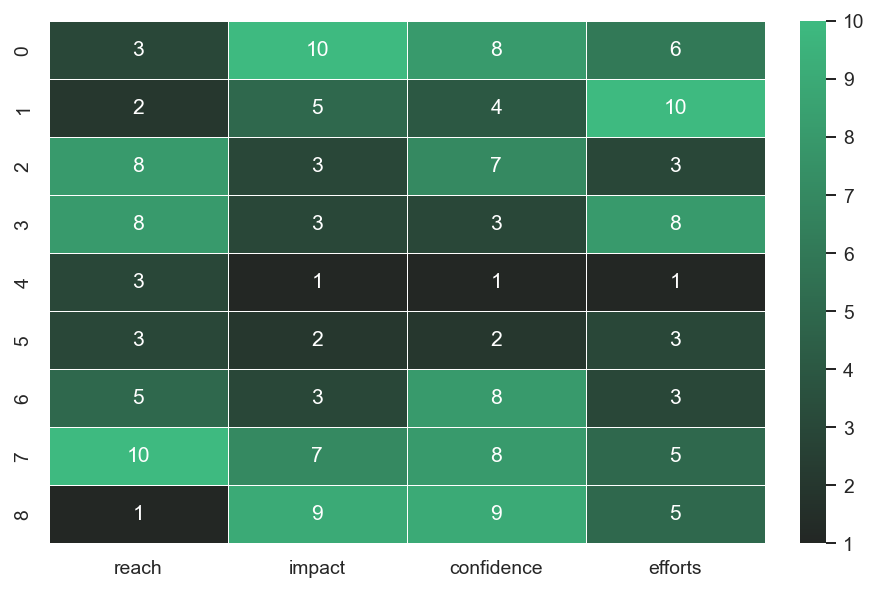

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
ax = sns.heatmap(h.select_dtypes(int), cmap=sns.dark_palette("#3eba80", as_cmap=True),
                 annot=True, linewidths=0.3)

## Фреймворк ICE и RICE для приоритизации гипотез

In [5]:
h['ice'] = np.round((h.impact * h.confidence) / h.efforts, 2)
h['rice'] = np.round((h.reach * h.impact * h.confidence) / h.efforts, 2)

with pd.option_context('display.max_colwidth', None):
    display(h.sort_values('ice', ascending=False)
            .select_dtypes([object, float]))

,hypothesis,ice,rice
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200,16.200
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.330,40.000
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200,112.000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000,40.000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000,56.000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000,4.000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.330,4.000
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.120,9.000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000,3.000


## Выводы

* Результат фреймворков различаются, так у ICE лучшими гипотезами являются - 8, 0 и 7, а у RICE - 7, 2 и 0.
* Приоритетными становятся гипотезы 0 и 7, которые попали в первую тройку обоих фреймворков.

# Запуск A/B-теста и анализ результатов

Загрузим данные и изучим общую информацию.

In [6]:
orders = pd.read_csv(url + 'orders.csv', parse_dates=[2])
visitors = pd.read_csv(url + 'visitors.csv',  parse_dates=[0])

for df in [orders, visitors]: df_analysis(df, 58)

,transactionid,visitorid,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionid  1197 non-null   int64         
 1   visitorid      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB
----------------------------------------------------------
Количество явных дубликатов:	0
Количество пропусков в данных:	0
----------------------------------------------------------



,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


----------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB
----------------------------------------------------------
Количество явных дубликатов:	0
Количество пропусков в данных:	0
----------------------------------------------------------



Поправим имена столбцов.

In [7]:
orders.rename(columns={'transactionid': 'transaction_id',
                       'visitorid': 'visitor_id'}, inplace=True)

## Обработка аномалий

Функция для поиска аномалий.

In [8]:
def anomaly_detection(data, contamination=0.01):
    model_knn = KNN(contamination=contamination).fit(data)
    estimation_knn = model_knn.labels_
    print(f'Количество аномалий: {sum(estimation_knn)}')
    return estimation_knn == 0

Посчитаем и уберем аномалии.

In [9]:
not_anomaly = anomaly_detection(
    visitors['visitors'].values.reshape(-1, 1))
visitors = visitors[not_anomaly]

Количество аномалий: 1


In [10]:
not_anomaly = anomaly_detection(
    orders['revenue'].values.reshape(-1, 1))
orders = orders[not_anomaly]

Количество аномалий: 12


## Графики кумулятивной выручки по дням по группам и кумулятивного среднего чека по группам

В agg_orders включим:

* дату;
* группу A/B-теста;
* число уникальных заказов в группе теста по указанную дату включительно;
* число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
* суммарную выручку заказов в группе теста по указанную дату включительно.

In [11]:
# Сначала проведем группировку.
agg_orders = orders.groupby([pd.Grouper(freq='D', key='date'), 'group']).agg({
    'transaction_id': 'count',
    'visitor_id': 'nunique',
    'revenue': 'sum'
}).reset_index()

# Теперь посчитаем набегающую сумму для каждой группы.
agg_orders[['transaction_id', 'visitor_id', 'revenue']] = \
    agg_orders.groupby('group')[['transaction_id', 'visitor_id', 'revenue']].transform('cumsum')

agg_orders.head()

,date,group,transaction_id,visitor_id,revenue
0,2019-08-01,A,24,20,148579
1,2019-08-01,B,21,20,101217
2,2019-08-02,A,44,39,242401
3,2019-08-02,B,45,43,266748
4,2019-08-03,A,68,63,354874


В agg_visitors включим:

* дату;
* группу A/B-теста;
* количество уникальных посетителей в группе теста по указанную дату включительно.

In [12]:
agg_visitors = visitors.copy()

agg_visitors['visitors'] = \
    agg_visitors.groupby('group')['visitors'].transform('cumsum')

agg_visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,1338
2,2019-08-03,A,1845
3,2019-08-04,A,2562
4,2019-08-05,A,3318


Объединим датафреймы.

In [13]:
cum_data = pd.merge(agg_orders, agg_visitors,
                    on=['group', 'date'])
cum_data.rename(columns={'transaction_id': 'orders', 'visitor_id': 'buyers'}, inplace=True)
cum_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,39,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,63,354874,1845


Построим графики.

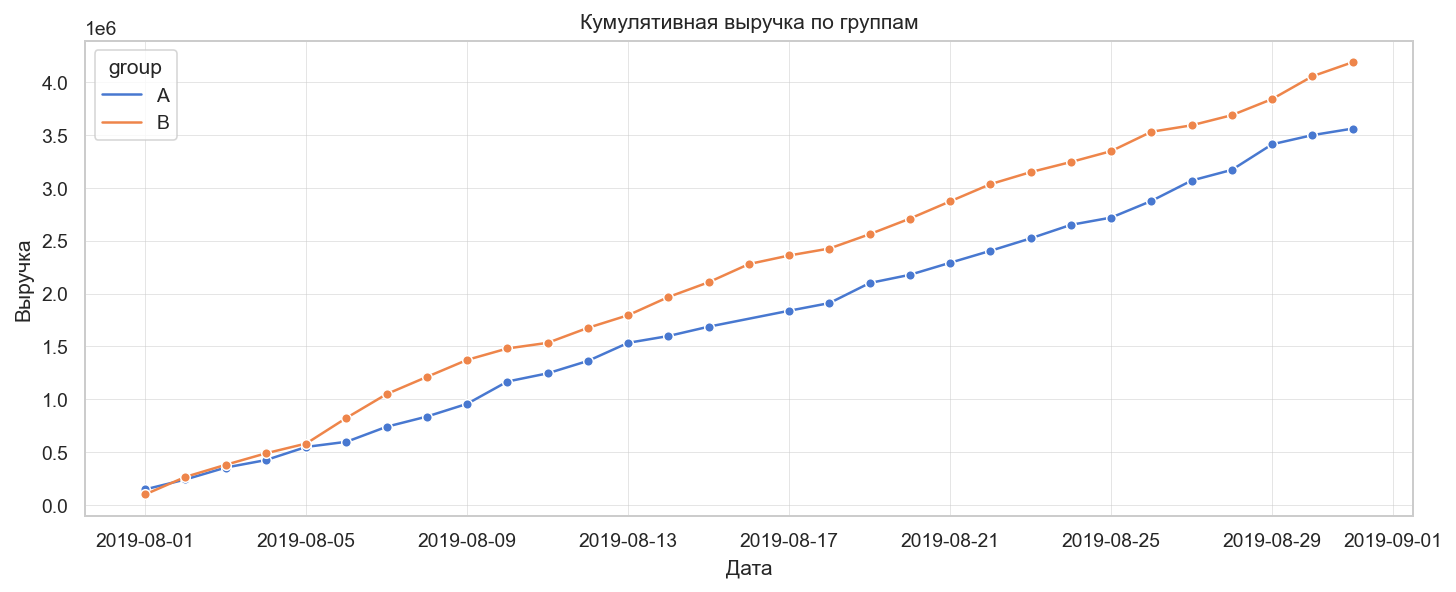

In [14]:
ax = sns.lineplot(data=cum_data, y='revenue', x='date', hue='group',
                  marker='o')
ax.set_title('Кумулятивная выручка по группам')
ax.set_xlabel("Дата")
ax.set_ylabel("Выручка");

С самого начала теста увеличение выручки сегментов шло равномерно с небольшим перевесом сторону сегмента 'В'.

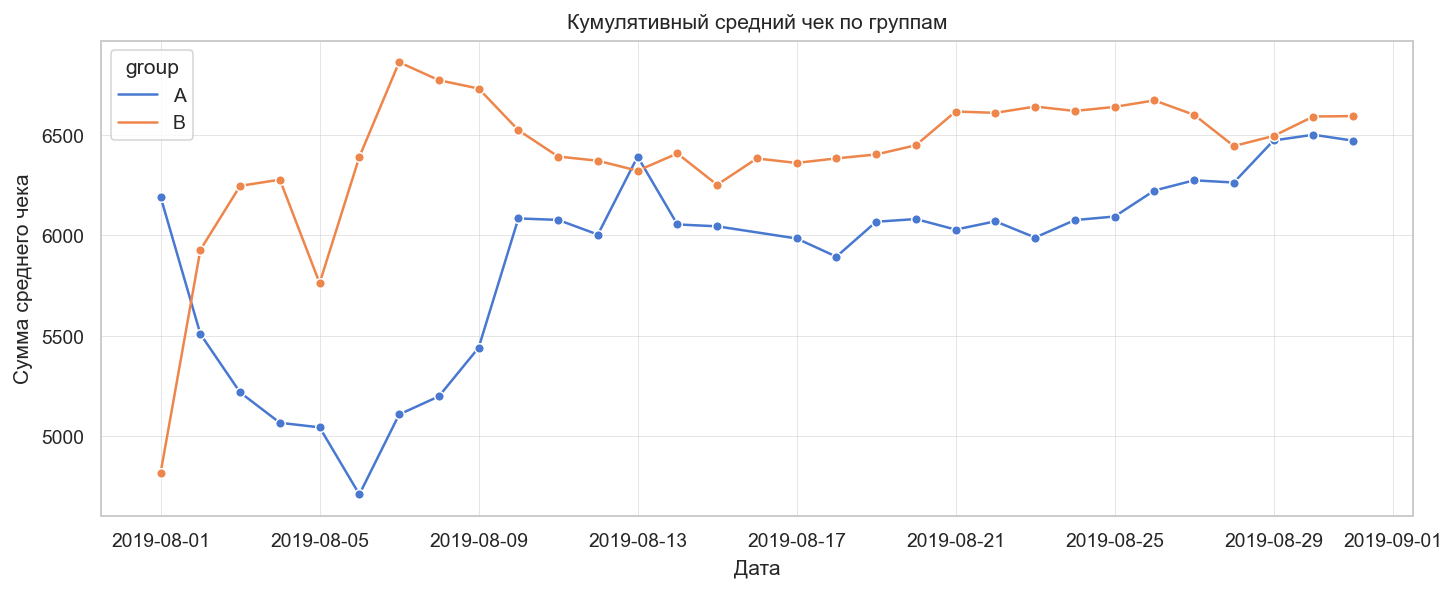

In [15]:
ax = sns.lineplot(data=cum_data, y=cum_data.revenue / cum_data.orders, x='date', hue='group',
                 marker='o')
ax.set_title('Кумулятивный средний чек по группам')
ax.set_xlabel("Дата")
ax.set_ylabel("Сумма среднего чека");

Кумулятивное значение среднего чека сегментов после колебаний в начале пришло к одному уровню.

## График кумулятивной конверсии по группам

После 5 августа конверсия в группе 'B' становится выше, в то время как в группе 'А' снижается. В дальнейшем конверсии стабилизируются.

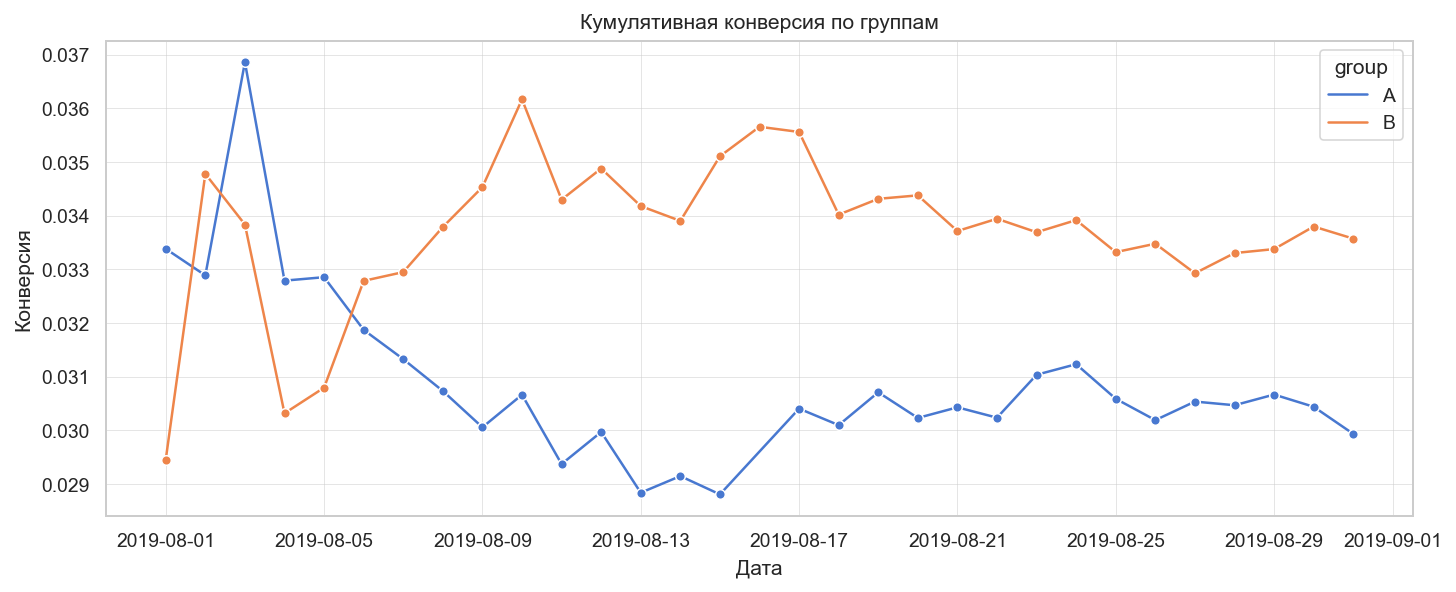

In [16]:
# Найдем конверсию.
cum_data['conversion'] = cum_data.orders / cum_data.visitors

ax = sns.lineplot(data=cum_data, y='conversion', x='date', hue='group',
                  marker='o')
ax.set_title('Кумулятивная конверсия по группам')
ax.set_xlabel("Дата")
ax.set_ylabel("Конверсия");

## График относительного изменения кумулятивного среднего чека группы 'A' к группе 'B'

Из графика видно затухание разницы между группами 'B' к 'A'.

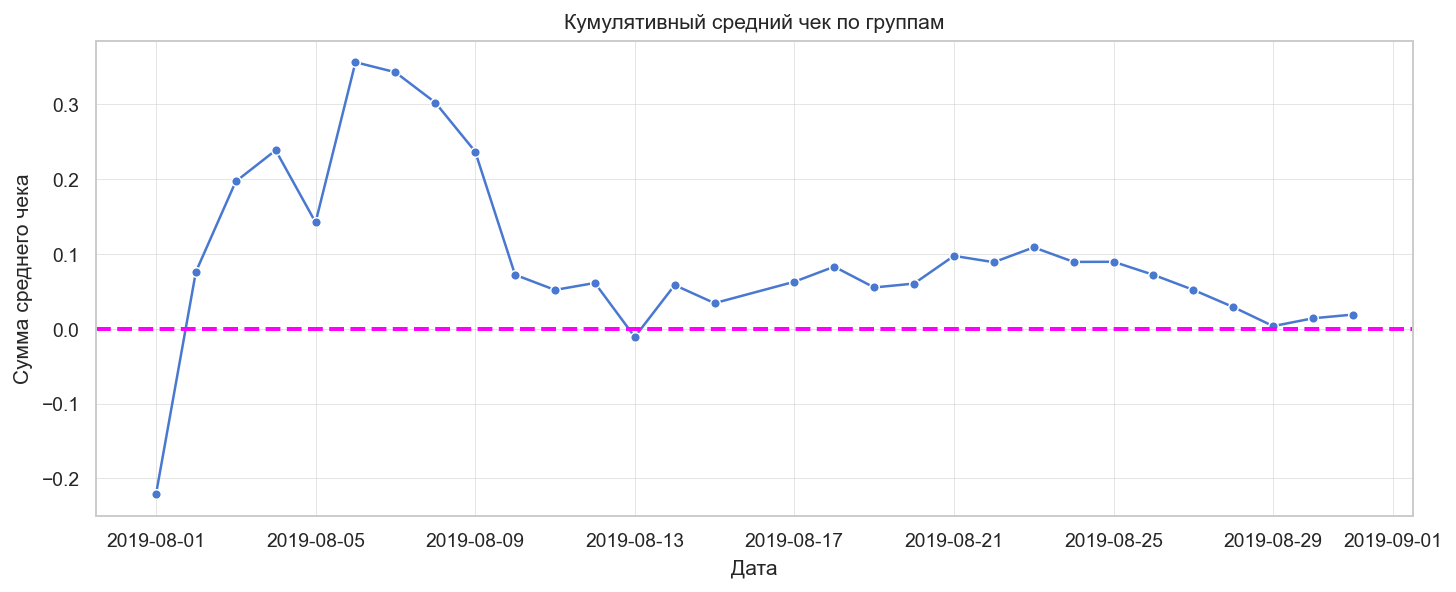

In [17]:
# Разделим cum_data по группам.
cum_data_a = cum_data.loc[cum_data.group == 'A',
                          ['date', 'revenue', 'orders', 'conversion']].set_index('date')
cum_data_b = cum_data.loc[cum_data.group == 'B',
                          ['date', 'revenue', 'orders', 'conversion']].set_index('date')

# Найдем отношение 'B' к 'A'.
b2a = (cum_data_b.revenue / cum_data_b.orders) \
    / (cum_data_a.revenue / cum_data_a.orders) - 1

ax = sns.lineplot(data=b2a, marker='o')
plt.axhline(y=0, color='magenta', linestyle='--', linewidth=2)

ax.set_title('Кумулятивный средний чек по группам')
ax.set_xlabel("Дата")
ax.set_ylabel("Сумма среднего чека");

## График относительного изменения кумулятивной конверсии группы 'B' к группе 'A'

Группа 'B' показывает лучший результат, стабилизируясь на отметке 15%.

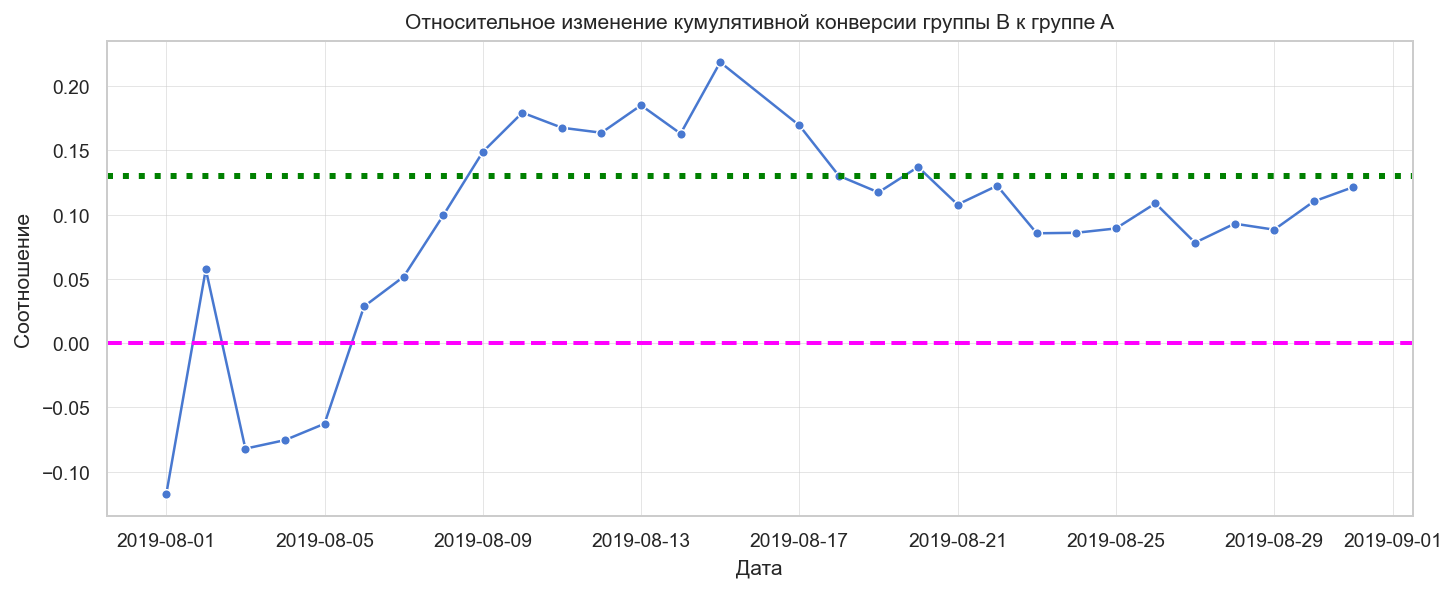

In [18]:
b2a = (cum_data_b.conversion) / (cum_data_a.conversion) - 1

ax = sns.lineplot(data=b2a, marker='o')
plt.axhline(y=0, color='magenta', linestyle='--', linewidth=2)
plt.axhline(y=0.13, color='green', linestyle=':', linewidth=3)

ax.set_title('Относительное изменение кумулятивной конверсии группы B к группе A')
ax.set_xlabel("Дата")
ax.set_ylabel("Соотношение");

## Точечный график количества заказов по пользователям

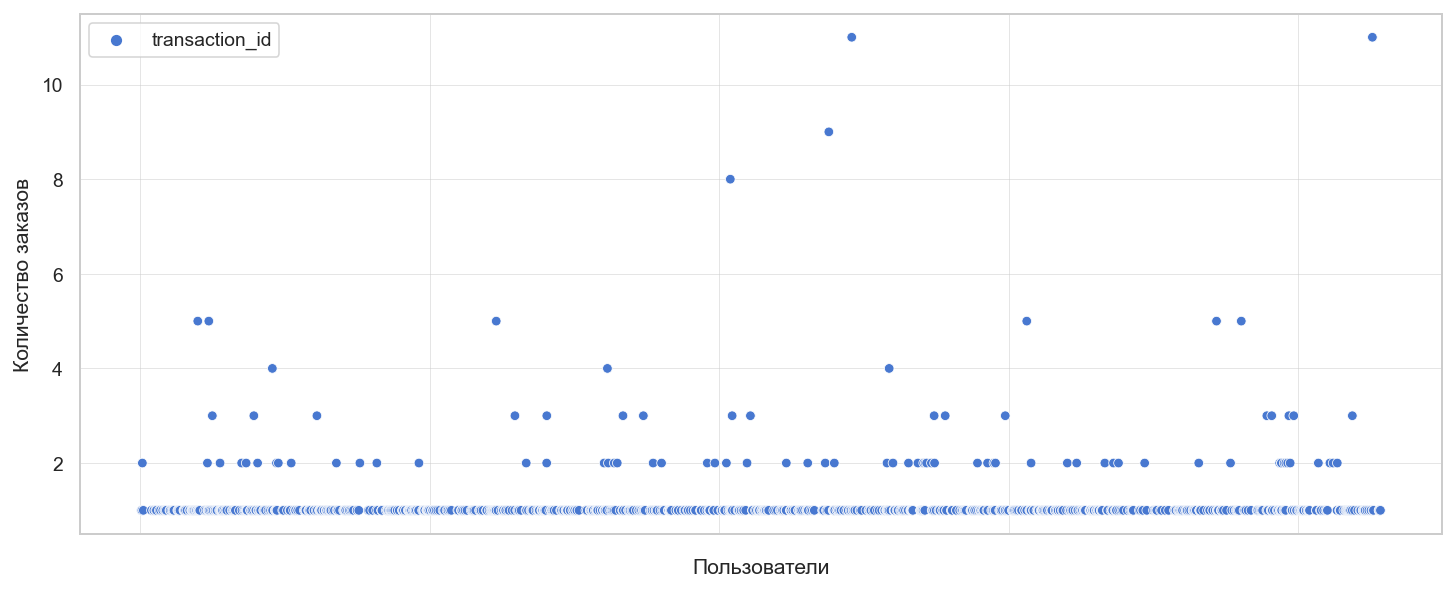

In [19]:
ax = sns.scatterplot(
    data=orders.groupby('visitor_id').agg({'transaction_id': 'count'}))

ax.set_ylabel("Количество заказов")
ax.set_xlabel("Пользователи")
ax.set_xticklabels('');

Большинство пользователей сделали всего один заказ, лишь единицы совершили 8 и более заказов. Не более 5% пользователей совершали больше двух заказов.

In [20]:
print(np.percentile(orders.groupby('visitor_id').agg({'transaction_id': 'count'}),
                    [90, 95, 99]))

[1. 2. 4.]


Исключим данные в которых более 6 заказов.

In [21]:
orders['transaction_cnt'] = orders.groupby('visitor_id')['transaction_id'].cumcount() + 1
orders = orders.query('transaction_cnt < 7')

## Точечный график стоимостей заказов

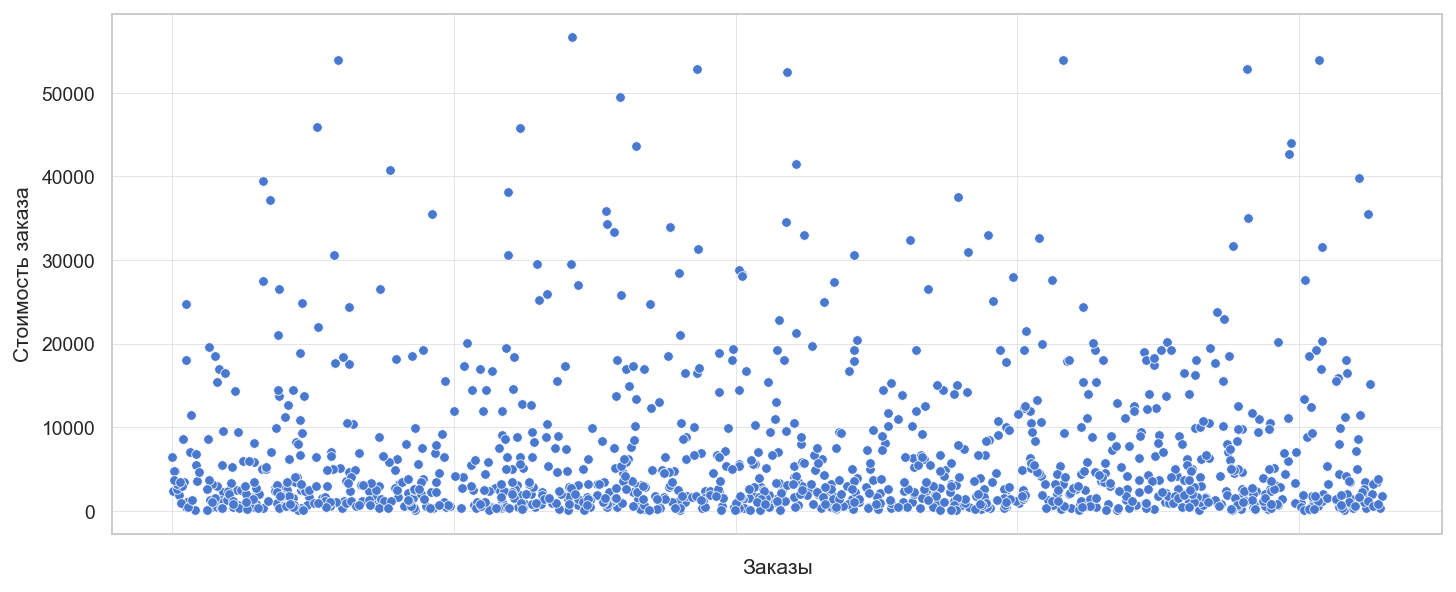

In [22]:
ax = sns.scatterplot(
    data=orders, x='transaction_id', y='revenue')

ax.set_ylabel("Стоимость заказа")
ax.set_xlabel("Заказы")
ax.set_xticklabels('');

Не более 5% заказов на сумму 24931, и всего у 1% - 43034.

In [23]:
print(np.percentile(orders['revenue'],
                    [90, 95, 99]))

[17799.6 24931.5 43034.5]


# Cтатистическую значимость различий в конверсии между группами

Для расчета статистики создадим датафрейм agg_data.

In [24]:
agg_data = visitors.merge(orders.groupby([pd.Grouper(freq='D', key='date'), 'group'])
                          .agg({'transaction_id': 'count'}).reset_index(),
                          on=['date', 'group'])

agg_data['conversion'] = agg_data.transaction_id / agg_data.visitors
agg_data.sample(5, random_state=38)

,date,group,visitors,transaction_id,conversion
40,2019-08-11,B,721,13,0.018
8,2019-08-09,A,617,15,0.024
17,2019-08-19,A,502,22,0.044
52,2019-08-23,B,546,15,0.027
0,2019-08-01,A,719,24,0.033


Зададим пороговое значение alpha.

In [25]:
alpha = 0.05

Воспользуемся Z-критерием, задав необходимые функции.

> Нулевая гипотеза h<sub>0</sub> -  конверсии в группе 'A' и 'B' одинаковые.

> Альтернативная гипотеза h<sub>1</sub> - конверсия в группе 'A' не равна конверсии в группе 'B'.

In [26]:
def pooled_standard_error(a, b, unbias=False):
    # Объединенная стандартная ошибка
    std1 = a.std(ddof=0) if unbias==False else a.std() 
    std2 = b.std(ddof=0) if unbias==False else b.std()
    x = std1**2 / a.count()
    y = std2**2 / b.count()
    return np.sqrt(x + y)

def z_stat(a, b, unbias=False):
    return (a.mean() - b.mean()) / pooled_standard_error(a, b, unbias)

def z_test(a, b): 
    return st.norm.cdf([ z_stat(a, b) ])[0]

In [27]:
a = agg_data.query('group == "A"')['conversion']
b = agg_data.query('group == "B"')['conversion']

pvalue = z_test(a, b)

print(f'z-статистика:\t{z_stat(a, b):.4f}')
print(f'p-значение:\t{pvalue:.4f}')

if (pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Разница статистически значима.')
else:
    print('Не отвергаем нулевую гипотезу. Статистически значимых различий нет.')

z-статистика:	-2.0723
p-значение:	0.0191
Отвергаем нулевую гипотезу. Разница статистически значима.


### Рассчитаем достоверность A/B тестирования

Выделим нужные для расчета данные.

In [28]:
data = cum_data.groupby('group').last()
data

,date,orders,buyers,revenue,visitors,conversion
group,,,,,,
A,2019-08-31,550,536,3558823,18375,0.030
B,2019-08-31,635,623,4186360,18916,0.034


In [29]:
# Количество посещений и заказов для групп А и B.
param_ctrl, convs_ctrl = data.loc['A', 'visitors'], data.loc['A', 'orders']
param_test, convs_test = data.loc['B', 'visitors'], data.loc['B', 'orders']

# Создаем beta функции для выборок.
a_C, b_C = convs_ctrl+1, param_ctrl - convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, param_test - convs_test+1
beta_T = beta(a_T, b_T)

# Расчитаем рост (или снижение если lift будет отрицательным).
lift = (beta_T.mean()-beta_C.mean()) / beta_C.mean()

# Вероятсноть того что группа B выдает результат лучше чем A.
prob = calc_prob_between(beta_T, beta_C)

print(f"Рост конверсии составил {lift:.2%} с вероятностью {prob:.1%}.")

Рост конверсии составил 12.13% с вероятностью 97.7%.


Также можно было воспользоваться онлайн калькулятором [A/B-test calculator by ABTestGuide.com](https://abtestguide.com/calc/)

# Статистическую значимость различий в среднем чеке заказа между группами

Воспользуемся критерием Манна-Уитни.

> Нулевая гипотеза h<sub>0</sub> -  средний чек 'A' равен среднему чеку группы 'B'.

> Альтернативная гипотеза h<sub>1</sub> - средний чек 'A' равен среднему чеку группы 'B'.

In [30]:
alpha = 0.05
results = st.mannwhitneyu(orders.query('group == "A"')['revenue'],
                          orders.query('group == "B"')['revenue'])

print(f'p-значение: {results.pvalue:.4f}')
if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу. Разница статистически значима.')
else:
    print('Не отвергаем нулевую гипотезу. Статистически значимых различий нет.')

p-значение: 0.6360
Не отвергаем нулевую гипотезу. Статистически значимых различий нет.


# Вывод

* Выбраны приоритетные гипотезы 0 и 7.
* Проведен A/B-теста. Результаты теста статистически значимы по конверсии, в группе 'B' имеем рост конверсии 12.13% с вероятностью 97.7%. A/B тест проведен успешно.
* Средний чек между группами значимых отличий не показал. Графически также можно наблюдать стабилизацию величины среднего чека у одинокого для обоих групп значения.